In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from lightfm import LightFM
from sklearn.preprocessing import normalize

from src.factorization import describe_csr_matrix

In [19]:
ratings = pd.read_csv('data/movie_ratings.csv', index_col='id')
movies = pd.read_csv('data/movie_info.csv', usecols=['id','title'], index_col='id')

ratings = ratings.join(movies, how='inner')
ratings.reset_index(drop=False, inplace=True)

ratings.head()

,id,user,rating,title
0,2,4,4.0,Jumanji
1,2,14,4.0,Jumanji
2,2,39,3.5,Jumanji
3,2,42,3.0,Jumanji
4,2,45,0.5,Jumanji


In [20]:
ratings['user_idx'] = ratings['user'].astype('category').cat.codes
ratings['movie_idx'] = ratings['id'].astype('category').cat.codes

ratings.head()

,id,user,rating,title,user_idx,movie_idx
0,2,4,4.0,Jumanji,3,0
1,2,14,4.0,Jumanji,12,0
2,2,39,3.5,Jumanji,35,0
3,2,42,3.0,Jumanji,37,0
4,2,45,0.5,Jumanji,40,0


In [21]:
ratings['value'] = np.where(ratings['rating'] >= 3.5, 1.0, -1.0)
ratings['value'].value_counts()

 1.0    15810170
-1.0     9643061
Name: value, dtype: int64

In [22]:
values = ratings['value'].values
idx = (ratings.user_idx.values, ratings.movie_idx.values,)
dim = (ratings.user_idx.max()+1, ratings.movie_idx.max()+1)
x = coo_matrix((values, idx), shape=dim)

print(describe_csr_matrix(x))

273627 x 10698 sparse matrix with 99.13% of sparsity.


In [23]:
%%time

N_COMPONENTS = 300
lfm = LightFM(no_components=N_COMPONENTS, loss='logistic', random_state=0)
lfm.fit(x, epochs=5, num_threads=8, verbose=False)

CPU times: user 32min 51s, sys: 956 ms, total: 32min 52s
Wall time: 4min 14s


In [24]:
movie_bias, movie_embedding = lfm.get_item_representations()
movie_embedding = normalize(movie_embedding, norm="l2", axis=1, copy=False)

print(movie_embedding.shape)
print(movie_embedding[:5, :5])

(10698, 300)
[[ 0.1372121  -0.03493307 -0.02981791  0.05093062  0.03932378]
 [ 0.04030022  0.02627787 -0.01587993  0.02087564 -0.09248517]
 [ 0.07503863 -0.06499472 -0.0544463   0.03757735  0.06549611]
 [ 0.05054996 -0.07873709 -0.03753362  0.05399195 -0.09292662]
 [ 0.0094167   0.00265179 -0.04744691 -0.03342406 -0.04624566]]


In [31]:
%%time

ratings['like'] = np.where(ratings['rating'] >= 3.5, 1.0, 0.0)
ratings['dislike'] = np.where(ratings['rating'] < 3.5, 1.0, 0.0)

movie_votes = ratings.groupby(['id']).agg(
    title = pd.NamedAgg(column='title', aggfunc='first'),
    num_votes = pd.NamedAgg(column='user_idx', aggfunc='count'),
    num_likes = pd.NamedAgg(column='like', aggfunc='sum'),
    num_dislikes = pd.NamedAgg(column='dislike', aggfunc='sum'),
    avg_rating = pd.NamedAgg(column='rating', aggfunc='mean'),
).reset_index(drop=False)
movie_votes['bias'] = movie_bias

movie_votes.head()

CPU times: user 2.46 s, sys: 612 ms, total: 3.07 s
Wall time: 3.06 s


,id,title,num_votes,num_likes,num_dislikes,avg_rating,bias
0,2,Jumanji,27138,12345.0,14793.0,3.246499,-0.310345
1,3,Grumpier Old Men,15579,5861.0,9718.0,3.173792,-0.631776
2,4,Waiting to Exhale,2989,848.0,2141.0,2.874540,-0.952598
3,5,Father of the Bride Part II,15466,5064.0,10402.0,3.077169,-1.133115
4,6,Heat,28680,20049.0,8631.0,3.844125,0.968931


<AxesSubplot:xlabel='num_votes', ylabel='bias'>

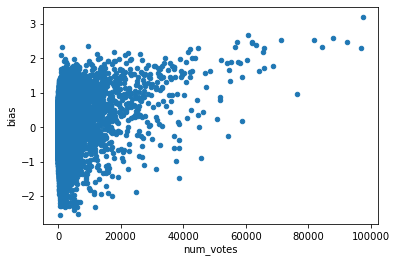

In [26]:
movie_votes.plot.scatter(x='num_votes', y='bias')

<AxesSubplot:xlabel='num_likes', ylabel='bias'>

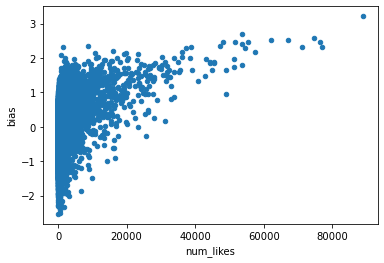

In [27]:
movie_votes.plot.scatter(x='num_likes', y='bias')

<AxesSubplot:xlabel='num_dislikes', ylabel='bias'>

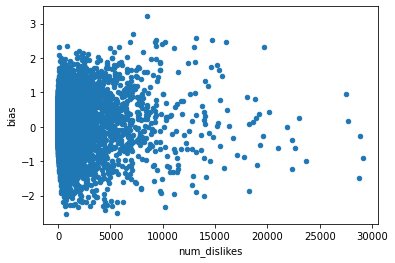

In [28]:
movie_votes.plot.scatter(x='num_dislikes', y='bias')

<AxesSubplot:xlabel='avg_rating', ylabel='bias'>

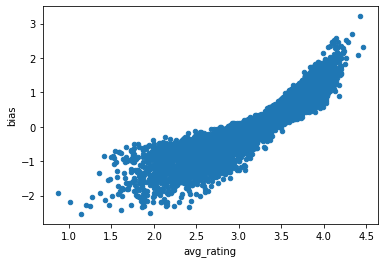

In [29]:
movie_votes.plot.scatter(x='avg_rating', y='bias')

In [32]:
%%time

movie_votes[['id','title']].to_csv('output/cb_embedding_meta.tsv', sep='\t', header=True, index=False)
pd.DataFrame(movie_embedding).to_csv('output/collab_filt_vectors.tsv', sep='\t', 
                                     float_format='%.5f', header=False, index=False)

CPU times: user 4.42 s, sys: 140 ms, total: 4.56 s
Wall time: 4.55 s


![](img/collab_filt_lord_rings.png)

![](img/collab_filt_star_wars.png)

![](img/collab_filt_pulp_fiction.png)